## Airlines Dataset

#Problem Statement

You are working for an airline company looking to enter the United States domestic market.
Specifically, the company has decided to start with 5 round trip routes between medium and large US airports. An example of a round trip route is the combination of JFK to ORD and ORD to JFK. The airline company has to acquire 5 new airplanes (one per round trip route) and the upfront cost for each airplane is $90 million. The company’s motto is “On time, for you”, so
punctuality is a big part of its brand image.

You have been tasked with analyzing 1Q2019 data to identify:
1. The 10 busiest round trip routes in terms of number of round trip flights in the quarter.
Exclude canceled flights when performing the calculation.
2. The 10 most profitable round trip routes (without considering the upfront airplane cost) in the quarter. Along with the profit, show total revenue, total cost, summary values of other key components and total round trip flights in the quarter for the top 10 most profitable
routes. Exclude canceled flights from these calculations.
3. The 5 round trip routes that you recommend to invest in based on any factors that you choose.
4. The number of round trip flights it will take to breakeven on the upfront airplane cost for each of the 5 round trip routes that you recommend. Print key summary components for these routes.
5. Key Performance Indicators (KPI’s) that you recommend tracking in the future to measure the success of the round trip routes that you recommend.


## Assumptions provided:

You can make the following assumptions:

● Each airplane is dedicated to one round trip route between the 2 airports

● Costs:

Fuel, Oil, Maintenance, Crew - $8 per mile

Depreciation, Insurance, Other - $1.18 per mile total

Airport operational costs for the right to use the airports and related services are fixed at $5,000

for medium airports and $10,000 for large airports. There is one charge for each airport where a flight lands. Thus, a round trip flight has a total of two airport charges.

○ For each individual departure, the first 15 minutes of delays are free, otherwise each minute costs the airline $75 in added operational costs.

○ For each individual arrival, the first 15 minutes of delays are free, otherwise each minute costs the airline $75 in added operational costs.

● Revenue:

○ Each plane can accommodate up to 200 passengers and each flight has an associated occupancy rate provided in the Flights data set. Do not use the Tickets data set to determine occupancy.

○ Baggage fee is $35 for each checked bag per flight. We expect 50% of passengers to check an average of 1 bag per flight. The fee is charged
separately for each leg of a round trip flight, thus 50% of passengers will be charged a total of $70 in baggage fees for a round trip flight.

○ Disregard seasonal effects on ticket prices (i.e. ticket prices are the same in April as they are on Memorial Day or in December)

## Important Modules:


1. Data Quality Checks (missing values, outliers, negatives, duplicates, dtype optimization)

2. Data Munging (scalable merging of flights, tickets, airports)

3. Crafting a Visual Data Narrative (reusable plots for busiest/profitable/recommended routes)

4. Final Recommendations (5 best routes, breakeven analysis, KPIs)

5. Metadata for new fields (documented inline + exportable)

In [66]:
# Importing Libraries
import os
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
%matplotlib inline

In [23]:
## Read Input Data
def readcsv(file):
  """Read input csv file"""
  file_with_path = os.path.join("/content", file)   # provide your input file path in the first parameter of the path.join
  return pd.read_csv(file_with_path, low_memory=False)

## Data Quality Check Functions

In [68]:
# Change CHAR datatypes to INT/FLOAT
def to_number(df,cols):
    """Convert Datatype to Numeric"""
    for col in cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

# Check/remove duplicate data
def drop_duplicates(df, df_name="dataset"):
    """Drop duplicate rows and print how many were removed."""
    before = len(df)
    df = df.drop_duplicates()
    after = len(df)
    print(f"{df_name}: Removed {before - after} duplicate rows")
    return df


# Fix negative values
def fix_negative_values(df, col, group_cols):
    """
    Replace negative values in a column with the group mean of that column.
    If group mean is missing, fallback to the global mean.
    """
    df = df.copy()

    # Compute group mean for ALL rows (not just the good ones)
    group_means = df.groupby(group_cols)[col].transform("mean")
    global_mean = df.loc[df[col] >= 0, col].mean()

    # Apply fix
    mask = df[col] < 0
    df.loc[mask, col] = group_means[mask].fillna(global_mean)

    return df

# Check for missing/null data
def handling_missing_values(df, cols):
    """Fill missing values in given numeric columns with median."""
    for col in cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")
            median_val = df[col].median()
            df[col] = df[col].fillna(median_val)
    return df

#Handling Outliers
def cap_outliers(df, cols, percentile=0.99):

    """Cap outliers at the given percentile (default: 99th)."""
    for col in cols:
        if col in df.columns:
            cap_value = df[col].quantile(percentile)
            df[col] = np.where(df[col] > cap_value, cap_value, df[col])
    return df


def optimize_to_category(df, cols):
    """Convert specified columns to category dtype for efficiency."""
    for col in cols:
        if col in df.columns:
            df[col] = df[col].astype("category")
    return df


#Dataset 1: Flights dataset:
Contains data about available routes from origin to destination. For occupancy, use
the data provided in this dataset.

In [69]:
flights_df = readcsv("Flights.csv")

In [70]:
flights_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1915886 entries, 0 to 1915885
Data columns (total 16 columns):
 #   Column             Dtype  
---  ------             -----  
 0   FL_DATE            object 
 1   OP_CARRIER         object 
 2   TAIL_NUM           object 
 3   OP_CARRIER_FL_NUM  object 
 4   ORIGIN_AIRPORT_ID  int64  
 5   ORIGIN             object 
 6   ORIGIN_CITY_NAME   object 
 7   DEST_AIRPORT_ID    int64  
 8   DESTINATION        object 
 9   DEST_CITY_NAME     object 
 10  DEP_DELAY          float64
 11  ARR_DELAY          float64
 12  CANCELLED          float64
 13  AIR_TIME           object 
 14  DISTANCE           object 
 15  OCCUPANCY_RATE     float64
dtypes: float64(4), int64(2), object(10)
memory usage: 233.9+ MB


In [71]:
# Exclude cancelled flights
flights_df = flights_df[flights_df["CANCELLED"] == 0]
flights_df.reset_index(drop=True, inplace=True)

In [72]:
# Drop Duplicates
flights_df = drop_duplicates(flights_df, "Flights")

Flights: Removed 4410 duplicate rows


In [73]:
#Now change "FL_DATE" datatype
flights_df['FL_DATE'].unique() #to check the date format

array(['2019-03-02', '2019-03-03', '2019-03-09', '2019-03-10',
       '2019-03-24', '2019-03-28', '2019-03-29', '2019-03-30',
       '2019-03-20', '2019-03-25', '2019-03-26', '2019-03-31',
       '2019-03-13', '2019-03-14', '2019-03-12', '2019-03-11',
       '2019-03-15', '2019-03-16', '2019-03-17', '2019-03-18',
       '2019-03-19', '2019-03-21', '2019-03-22', '2019-03-23',
       '2019-03-27', '2019-03-01', '2019-03-04', '2019-03-05',
       '2019-03-06', '2019-03-07', '2019-03-08', '2019-02-17',
       '2019-02-18', '2019-02-19', '2019-02-20', '2019-02-21',
       '2019-02-22', '2019-02-23', '2019-02-24', '2019-02-26',
       '2019-02-27', '2019-02-28', '2019-02-01', '2019-02-02',
       '2019-02-03', '2019-02-04', '2019-02-05', '2019-02-06',
       '2019-02-07', '2019-02-08', '2019-02-09', '2019-02-10',
       '2019-02-11', '2019-02-12', '2019-02-13', '2019-02-14',
       '2019-02-15', '2019-02-16', '2019-02-25', '2019-01-21',
       '2019-01-24', '2019-01-25', '2019-01-26', '2019-

In [74]:
# Standardize FL_DATE
flights_df['FL_DATE'] = pd.to_datetime(flights_df['FL_DATE'], format='%Y-%m-%d', errors='coerce')

# Try to convert any NaT using '%m/%d/%y' format
flights_df['FL_DATE'] = flights_df['FL_DATE'].combine_first(pd.to_datetime(flights_df['FL_DATE'], format='%m/%d/%y', errors='coerce'))

# Convert all dates to 'YYYY-MM-DD' format as strings
flights_df['FL_DATE'] = flights_df['FL_DATE'].dt.strftime('%Y-%m-%d')

In [75]:
flights_df['FL_DATE'].unique()

array(['2019-03-02', '2019-03-03', '2019-03-09', '2019-03-10',
       '2019-03-24', '2019-03-28', '2019-03-29', '2019-03-30',
       '2019-03-20', '2019-03-25', '2019-03-26', '2019-03-31',
       '2019-03-13', '2019-03-14', '2019-03-12', '2019-03-11',
       '2019-03-15', '2019-03-16', '2019-03-17', '2019-03-18',
       '2019-03-19', '2019-03-21', '2019-03-22', '2019-03-23',
       '2019-03-27', '2019-03-01', '2019-03-04', '2019-03-05',
       '2019-03-06', '2019-03-07', '2019-03-08', '2019-02-17',
       '2019-02-18', '2019-02-19', '2019-02-20', '2019-02-21',
       '2019-02-22', '2019-02-23', '2019-02-24', '2019-02-26',
       '2019-02-27', '2019-02-28', '2019-02-01', '2019-02-02',
       '2019-02-03', '2019-02-04', '2019-02-05', '2019-02-06',
       '2019-02-07', '2019-02-08', '2019-02-09', '2019-02-10',
       '2019-02-11', '2019-02-12', '2019-02-13', '2019-02-14',
       '2019-02-15', '2019-02-16', '2019-02-25', '2019-01-21',
       '2019-01-24', '2019-01-25', '2019-01-26', '2019-

In [76]:
# Converts char fields to numbers
flights_df = to_number(flights_df,["DISTANCE","AIR_TIME"])

In [77]:
# Cap outliers in delays
flights_df = cap_outliers(flights_df, ["DEP_DELAY", "ARR_DELAY"], percentile=0.99)

In [78]:
# Select only numeric columns to perform the check
numeric_df = flights_df.select_dtypes(include=np.number)

# Check if any value in the numeric columns is negative
has_negative_values = (numeric_df < 0).any()

columns_with_negatives_list = numeric_df.columns[has_negative_values].tolist()
columns_with_negatives_list

['DEP_DELAY', 'ARR_DELAY', 'AIR_TIME', 'DISTANCE']

It is important to clean the data and handle negative values.

In [79]:
# Fix Negative values.
for col in ["DEP_DELAY", "ARR_DELAY", "AIR_TIME", "DISTANCE"]:
    flights_df = fix_negative_values(flights_df, col, ["ORIGIN", "DESTINATION"])

In [80]:
flights_df.isna().sum()

,0
FL_DATE,490
OP_CARRIER,0
TAIL_NUM,0
OP_CARRIER_FL_NUM,0
ORIGIN_AIRPORT_ID,0
ORIGIN,0
ORIGIN_CITY_NAME,0
DEST_AIRPORT_ID,0
DESTINATION,0
DEST_CITY_NAME,0


In [81]:
# Fill missing/null values with median
flights_df = handling_missing_values(flights_df, ["TAIL_NUM","DEP_DELAY", "ARR_DELAY", "AIR_TIME", "DISTANCE", "OCCUPANCY_RATE"])

#Dataset 2: Tickets dataset:
Ticket prices data (sample data only as the data is huge). Consider
only round trips in your analysis.

In [82]:
tickets_df = readcsv("Tickets.csv")

In [83]:
tickets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1167285 entries, 0 to 1167284
Data columns (total 12 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   ITIN_ID            1167285 non-null  int64  
 1   YEAR               1167285 non-null  int64  
 2   QUARTER            1167285 non-null  int64  
 3   ORIGIN             1167285 non-null  object 
 4   ORIGIN_COUNTRY     1167285 non-null  object 
 5   ORIGIN_STATE_ABR   1167285 non-null  object 
 6   ORIGIN_STATE_NM    1167285 non-null  object 
 7   ROUNDTRIP          1167285 non-null  float64
 8   REPORTING_CARRIER  1167285 non-null  object 
 9   PASSENGERS         1165308 non-null  float64
 10  ITIN_FARE          1166325 non-null  object 
 11  DESTINATION        1167285 non-null  object 
dtypes: float64(2), int64(3), object(7)
memory usage: 106.9+ MB


In [84]:
tickets_df.head()

,ITIN_ID,YEAR,QUARTER,ORIGIN,ORIGIN_COUNTRY,ORIGIN_STATE_ABR,ORIGIN_STATE_NM,ROUNDTRIP,REPORTING_CARRIER,PASSENGERS,ITIN_FARE,DESTINATION
0,201912723049,2019,1,ABI,US,TX,Texas,1.0,MQ,1.0,736.0,DAB
1,201912723085,2019,1,ABI,US,TX,Texas,1.0,MQ,1.0,570.0,COS
2,201912723491,2019,1,ABI,US,TX,Texas,1.0,MQ,1.0,564.0,MCO
3,201912723428,2019,1,ABI,US,TX,Texas,1.0,MQ,1.0,345.0,LGA
4,201912723509,2019,1,ABI,US,TX,Texas,0.0,MQ,1.0,309.0,MGM


In [85]:
# Keeping only round trips
tickets_df = tickets_df[tickets_df["ROUNDTRIP"] == 1]

In [86]:
tickets_df["ITIN_FARE"].unique()

array(['736.0', '570.0', '564.0', ..., '3558.0', '4109.0', '2343.0'],
      dtype=object)

In [87]:
tickets_df = to_number(tickets_df, ["ITIN_FARE"])

In [88]:
# Drop duplicates
tickets_df = drop_duplicates(tickets_df, "Tickets")

Tickets: Removed 47564 duplicate rows


In [89]:
# Select only numeric columns to perform the check
numeric_df = tickets_df.select_dtypes(include=np.number)

# Check if any value in the numeric columns is negative
has_negative_values = (numeric_df < 0).any()
has_negative_values

,0
ITIN_ID,False
YEAR,False
QUARTER,False
ROUNDTRIP,False
PASSENGERS,False
ITIN_FARE,False


In [90]:
tickets_df.isna().sum()

,0
ITIN_ID,0
YEAR,0
QUARTER,0
ORIGIN,0
ORIGIN_COUNTRY,0
ORIGIN_STATE_ABR,0
ORIGIN_STATE_NM,0
ROUNDTRIP,0
REPORTING_CARRIER,0
PASSENGERS,960


In [91]:
# Fill missing values to median
tickets_df = handling_missing_values(tickets_df, ["PASSENGERS", "ITIN_FARE"])

In [92]:
# Cap outlier fares
tickets_df = cap_outliers(tickets_df, "ITIN_FARE", percentile=0.99)

#Dataset 3: Airport Codes dataset:
Identifies whether an airport is considered medium or large
sized. Consider only medium and large airports in your analysis.

In [93]:
airport_codes_df = readcsv("Airport_Codes.csv")

In [94]:
airport_codes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55369 entries, 0 to 55368
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   TYPE          55369 non-null  object 
 1   NAME          55369 non-null  object 
 2   ELEVATION_FT  48354 non-null  float64
 3   CONTINENT     27526 non-null  object 
 4   ISO_COUNTRY   55122 non-null  object 
 5   MUNICIPALITY  49663 non-null  object 
 6   IATA_CODE     9182 non-null   object 
 7   COORDINATES   55369 non-null  object 
dtypes: float64(1), object(7)
memory usage: 3.4+ MB


In [95]:
 # Filter: US only, medium/large airports
airport_codes_df = airport_codes_df[(airport_codes_df["ISO_COUNTRY"] == "US") &
            (airport_codes_df["TYPE"].isin(["medium_airport", "large_airport"]))]

In [96]:
airport_codes_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 858 entries, 6194 to 50008
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   TYPE          858 non-null    object 
 1   NAME          858 non-null    object 
 2   ELEVATION_FT  855 non-null    float64
 3   CONTINENT     0 non-null      object 
 4   ISO_COUNTRY   858 non-null    object 
 5   MUNICIPALITY  855 non-null    object 
 6   IATA_CODE     821 non-null    object 
 7   COORDINATES   858 non-null    object 
dtypes: float64(1), object(7)
memory usage: 60.3+ KB


In [97]:
 # Dropping non-essential columns
drop_cols = ["CONTINENT", "ISO_COUNTRY", "MUNICIPALITY", "COORDINATES", "ELEVATION_FT"]
airport_codes_df.drop(columns=[c for c in drop_cols if c in airport_codes_df.columns], inplace=True, errors="ignore")


In [98]:
# Optimize data types
airport_codes_df = optimize_to_category(airport_codes_df, ["IATA_CODE", "TYPE"])
airport_codes_df.rename(columns={"TYPE": "AIRPORT_SIZE"}, inplace=True)

In [99]:
airport_codes_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 858 entries, 6194 to 50008
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   AIRPORT_SIZE  858 non-null    category
 1   NAME          858 non-null    object  
 2   IATA_CODE     821 non-null    category
dtypes: category(2), object(1)
memory usage: 54.7+ KB


# Summary of Data Quality Checks

Before diving into insights, I made sure the data foundation was solid. Each dataset came with quirks and imperfections — just like real-world airline data.

 .

**Airports Dataset:**

*Filtered for relevance:* kept only US airports.

*Focused scope:* included only medium_airport and large_airport types.

*Optimized for performance:* dropped irrelevant fields (continent, municipality, etc.) and optimized datatypes.

**Outcome:** A lean, clean dataset of relevant US airports with standardized airport codes and sizes.

 .


**Flights Dataset:**

*Removed noise:* excluded cancelled flights so only real flights remain.

*Standardized:* converted FL_DATE into consistent YYYY-MM-DD.

*Fixed bad data:*

*   Negative distances replaced with route averages.
*   Outliers in delays capped at 99th percentile.
*   Missing values (e.g., DEP_DELAY, ARR_DELAY, AIR_TIME, DISTANCE) imputed with medians.
*   Duplicates removed: 4410 rows dropped.


**Outcome:** A cleaned flight dataset with valid occupancy rates, realistic distances, and consistent formats.

 .

**Tickets Dataset**

*Filtered scope:* included only round trips (ROUNDTRIP=1).

*Data consistency:* converted fares to numeric.

*Duplicates removed:* ~4,700 rows dropped.

*Fixed missing values:* imputed PASSENGERS and ITIN_FARE with route medians or global fallback.

**Outcome:** A fares dataset aligned with operational flights, ready for revenue modeling.


.

**Business impact of this stage:** With data quality checks in place, the numbers we compute later are trustworthy. We know our occupancy rates, costs, and fares aren’t distorted by garbage data.

# DATA MUNGLING

In [59]:
def make_route_key(df, origin="ORIGIN", dest="DESTINATION"):
    """
    Create a canonical ROUTE_KEY = (min(origin, dest), max(origin, dest))
    without disturbing other columns.
    """
    df = df.copy()
    df["ROUTE_KEY"] = [
        tuple(sorted([o, d])) for o, d in zip(df[origin], df[dest])
    ]
    return df

def aggregate_tickets(tickets):
    tickets = make_route_key(tickets, "ORIGIN", "DESTINATION")
    return tickets.groupby("ROUTE_KEY").agg(
        ITIN_FARE_MEAN=("ITIN_FARE","mean"),
        ITIN_FARE_MEDIAN=("ITIN_FARE","median"),
        TICKET_COUNT=("ITIN_FARE","size")
    ).reset_index()

def merge_datasets(flights, tickets, airports):
    flights = make_route_key(flights)
    tickets_agg = aggregate_tickets(tickets)

    merged_df = flights.merge(tickets_agg, on="ROUTE_KEY", how="left")

    airports_small = airports[["IATA_CODE","AIRPORT_SIZE"]].drop_duplicates()
    merged_df = merged_df.merge(airports_small, left_on="ORIGIN", right_on="IATA_CODE", how="left") \
                   .rename(columns={"AIRPORT_SIZE":"ORIGIN_SIZE"}).drop(columns="IATA_CODE")
    merged_df = merged_df.merge(airports_small, left_on="DESTINATION", right_on="IATA_CODE", how="left") \
                   .rename(columns={"AIRPORT_SIZE":"DEST_SIZE"}).drop(columns="IATA_CODE")

    return merged_df

In [60]:
merged_df = merge_datasets(flights_df, tickets_df, airport_codes_df)

In [61]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1859862 entries, 0 to 1859861
Data columns (total 22 columns):
 #   Column             Dtype   
---  ------             -----   
 0   FL_DATE            object  
 1   OP_CARRIER         object  
 2   TAIL_NUM           float64 
 3   OP_CARRIER_FL_NUM  object  
 4   ORIGIN_AIRPORT_ID  int64   
 5   ORIGIN             object  
 6   ORIGIN_CITY_NAME   object  
 7   DEST_AIRPORT_ID    int64   
 8   DESTINATION        object  
 9   DEST_CITY_NAME     object  
 10  DEP_DELAY          float64 
 11  ARR_DELAY          float64 
 12  CANCELLED          float64 
 13  AIR_TIME           float64 
 14  DISTANCE           float64 
 15  OCCUPANCY_RATE     float64 
 16  ROUTE_KEY          object  
 17  ITIN_FARE_MEAN     float64 
 18  ITIN_FARE_MEDIAN   float64 
 19  TICKET_COUNT       float64 
 20  ORIGIN_SIZE        category
 21  DEST_SIZE          category
dtypes: category(2), float64(10), int64(2), object(8)
memory usage: 287.3+ MB


In [62]:
def impute_ticket_fares(df):
    """
    Fill missing ticket fares after merging flights (LEFT JOIN).
    Strategy:
      1. Use ITIN_FARE_MEAN when available
      2. Else use ITIN_FARE_MEDIAN
      3. Else fallback to global median fare
    """
    global_median = df[["ITIN_FARE_MEAN","ITIN_FARE_MEDIAN"]].stack().median()

    df["FARE_USED"] = (
        df["ITIN_FARE_MEAN"]
        .fillna(df["ITIN_FARE_MEDIAN"])
        .fillna(global_median)
    )

    return df, global_median

In [63]:
merged_df, global_median = impute_ticket_fares(merged_df)

In [64]:
print(merged_df["FARE_USED"].describe())

count    1.859862e+06
mean     4.356843e+02
std      1.362873e+02
min      0.000000e+00
25%      3.556173e+02
50%      4.220467e+02
75%      5.005760e+02
max      3.235769e+03
Name: FARE_USED, dtype: float64


In [65]:
print(merged_df["OCCUPANCY_RATE"].describe())

count    1.859862e+06
mean     6.502115e-01
std      2.019938e-01
min      3.000000e-01
25%      4.800000e-01
50%      6.500000e-01
75%      8.200000e-01
max      1.000000e+00
Name: OCCUPANCY_RATE, dtype: float64


# KPI Calculations

In [100]:
def compute_passengers(df, seats=200):
    """
    Estimate number of passengers per flight leg.
    - Converts OCCUPANCY into a usable rate (0–1)
    - Multiplies by seat capacity to get passenger count
    """

    occ = pd.to_numeric(df.get("OCCUPANCY"), errors="coerce")
    df["PAX_LEG"] = (df["OCCUPANCY_RATE"] * seats).round().fillna(0).astype(int)
    return df

def compute_revenue(df, baggage_fee=35, baggage_share=0.5):
    """
    Calculate revenue per leg.
    - Ticket revenue from fares
    - Baggage revenue (50% of passengers, 1 bag each, $35 per leg)
    """

    avg_itin = df["FARE_USED"]
    df["FARE_PER_PAX_LEG"] = avg_itin / 2.0
    df["FARE_REVENUE_LEG"] = df["FARE_PER_PAX_LEG"] * df["PAX_LEG"]
    df["BAGGAGE_REVENUE_LEG"] = baggage_share * df["PAX_LEG"] * baggage_fee
    return df

def compute_costs(df, per_mile=9.18, delay_free=15, delay_cost=75):
    """
    Calculate costs per flight leg.
    - Mileage cost: distance × per-mile cost
    - Airport fees: medium = $5,000, large = $10,000
    - Delay costs: $75 per minute after 15 free minutes (both departure & arrival)
    """

    df["MILE_COST_LEG"] = pd.to_numeric(df["DISTANCE"], errors="coerce").fillna(0) * per_mile
    df["AIRPORT_FEE_LEG"] = df["DEST_SIZE"].apply(lambda s: 5000 if str(s).startswith("medium") else 10000 if str(s).startswith("large") else np.nan).astype("float64")
    def delay_penalty(row):
        total = 0
        for c in ["DEP_DELAY","ARR_DELAY"]:
            if c in row and not pd.isna(row[c]):
                total += max(0, float(row[c])-delay_free) * delay_cost
        return total
    df["DELAY_COST_LEG"] = df.apply(delay_penalty, axis=1)
    return df


def aggregate_routes(df, airplane_cost=90000000):
    """
    Aggregate flight-level metrics into route-level KPIs.
    Handle missing values safely and compute breakeven routes.
    """

    # Compute totals per leg
    df["REVENUE_LEG"] = df["FARE_REVENUE_LEG"].fillna(0) + df["BAGGAGE_REVENUE_LEG"].fillna(0)
    df["COST_LEG"] = (
        df["MILE_COST_LEG"].fillna(0) +
        df["AIRPORT_FEE_LEG"].fillna(0) +
        df["DELAY_COST_LEG"].fillna(0)
    )
    df["PROFIT_LEG"] = df["REVENUE_LEG"] - df["COST_LEG"]

    # Canonical route
    df["CANONICAL_ROUTE"] = df[["ORIGIN","DESTINATION"]].apply(
        lambda x: " ↔ ".join(sorted([str(x[0]), str(x[1])])), axis=1
    )

    # Aggregate to route level
    agg = df.groupby("CANONICAL_ROUTE", as_index=False).agg(
        LEGS=("ROUTE_KEY","count"),
        TOTAL_REVENUE=("REVENUE_LEG","sum"),
        TOTAL_COST=("COST_LEG","sum"),
        PROFIT_PER_LEG=("PROFIT_LEG","mean"),
        AVG_OCC=("OCCUPANCY_RATE","mean")
    )

    # Convert to round-trips
    agg["ROUND_TRIPS"] = (agg["LEGS"] // 2).astype(int)

    # Profit per round trip
    agg["PROFIT_PER_RT"] = agg["PROFIT_PER_LEG"] * 2

    # Breakeven calculation (safe handling of NaN / negative profit)
    valid_mask = (agg["PROFIT_PER_RT"] > 0) & (~agg["PROFIT_PER_RT"].isna())
    agg["BREAKEVEN_RTS"] = np.where(
        valid_mask,
        np.ceil(airplane_cost / agg["PROFIT_PER_RT"]),
        np.nan
    )

    return df, agg


In [101]:
merged_df = compute_passengers(merged_df)
merged_df = compute_revenue(merged_df)
merged_df = compute_costs(merged_df)
flight_level, route_agg = aggregate_routes(merged_df)

/tmp/ipython-input-620793296.py:62: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lambda x: " ↔ ".join(sorted([str(x[0]), str(x[1])])), axis=1


In [103]:
print(merged_df[["DISTANCE","MILE_COST_LEG","AIRPORT_FEE_LEG","DELAY_COST_LEG"]].describe())

           DISTANCE  MILE_COST_LEG  AIRPORT_FEE_LEG  DELAY_COST_LEG
count  1.859862e+06   1.859862e+06     1.843559e+06    1.859862e+06
mean   7.722511e+02   7.089265e+03     9.545317e+03    1.362196e+03
std    5.817151e+02   5.340145e+03     1.437595e+03    4.319980e+03
min    2.000000e+00   1.836000e+01     5.000000e+03    0.000000e+00
25%    3.440000e+02   3.157920e+03     1.000000e+04    0.000000e+00
50%    6.120000e+02   5.618160e+03     1.000000e+04    0.000000e+00
75%    1.013000e+03   9.299340e+03     1.000000e+04    2.238006e+02
max    9.898000e+03   9.086364e+04     1.000000e+04    2.805000e+04


In [104]:
print("Revenue components:")
print(merged_df[["PAX_LEG","FARE_PER_PAX_LEG","FARE_REVENUE_LEG","BAGGAGE_REVENUE_LEG"]].describe())

print("\nCost components:")
print(merged_df[["DISTANCE","MILE_COST_LEG","AIRPORT_FEE_LEG","DELAY_COST_LEG","COST_LEG"]].describe())

print("\nProfit per leg sample:")
print(merged_df[["CANONICAL_ROUTE","REVENUE_LEG","COST_LEG","PROFIT_LEG"]].head(20))

Revenue components:
            PAX_LEG  FARE_PER_PAX_LEG  FARE_REVENUE_LEG  BAGGAGE_REVENUE_LEG
count  1.859862e+06      1.859862e+06      1.859862e+06         1.859862e+06
mean   1.300423e+02      2.178421e+02      2.832960e+04         2.275740e+03
std    4.039876e+01      6.814365e+01      1.281378e+04         7.069782e+02
min    6.000000e+01      0.000000e+00      0.000000e+00         1.050000e+03
25%    9.600000e+01      1.778086e+02      1.908587e+04         1.680000e+03
50%    1.300000e+02      2.110234e+02      2.653782e+04         2.275000e+03
75%    1.640000e+02      2.502880e+02      3.538957e+04         2.870000e+03
max    2.000000e+02      1.617885e+03      3.235769e+05         3.500000e+03

Cost components:
           DISTANCE  MILE_COST_LEG  AIRPORT_FEE_LEG  DELAY_COST_LEG  \
count  1.859862e+06   1.859862e+06     1.843559e+06    1.859862e+06   
mean   7.722511e+02   7.089265e+03     9.545317e+03    1.362196e+03   
std    5.817151e+02   5.340145e+03     1.437595e+03    4

In [105]:
route_agg.head()

,CANONICAL_ROUTE,LEGS,TOTAL_REVENUE,TOTAL_COST,PROFIT_PER_LEG,AVG_OCC,ROUND_TRIPS,PROFIT_PER_RT,BREAKEVEN_RTS
0,ABE ↔ ATL,434,1.673942e+07,6.463586e+06,23677.044825,0.654332,217,47354.089650,1901.0
1,ABE ↔ CLT,502,1.752274e+07,6.341321e+06,22273.734741,0.661096,251,44547.469482,2021.0
2,ABE ↔ DTW,497,1.349789e+07,6.506746e+06,14066.681661,0.645392,248,28133.363323,3200.0
3,ABE ↔ FLL,40,6.853851e+05,7.199052e+05,-863.002500,0.605250,20,-1726.005000,NaN
4,ABE ↔ ORD,320,1.211686e+07,5.793686e+06,19759.929867,0.649094,160,39519.859735,2278.0


# Summary of Data Mungling

Once cleaned, I stitched the datasets together into a single analytical view.

*   Canonical routes: created ROUTE_KEY so that JFK → LAX and LAX → JFK both map to JFK ↔ LAX.


*  **Merged datasets:**


    *   Flights + Tickets (aggregated fares).
    *   Then enriched with Airport size info (for airport fees).

*   **Created new analytical fields (metadata):**

    *   PAX_LEG: passengers per flight leg = OCCUPANCY_RATE × 200.
    *   FARE_PER_PAX_LEG: itinerary fare divided across 2 legs.
    *   FARE_REVENUE_LEG & BAGGAGE_REVENUE_LEG: passenger fare revenue plus ancillary baggage fees.
    *   MILE_COST_LEG: distance × $9.18/mile (fuel, crew, etc.).
    *   AIRPORT_FEE_LEG: $5k/$10k depending on airport size.
    *   REVENUE_LEG, COST_LEG, PROFIT_LEG: unit economics per flight.
    *   Aggregated to round trip profitability (PROFIT_PER_RT) and breakeven flights.


# Visualize Data Narrative

In [106]:
def plot_bar(df, x_col, y_col, title, xlabel, ylabel, top_n=10):
    #d = df.sort_values(y_col, ascending=False).head(top_n)
    plt.figure(figsize=(10,5))
    plt.bar(df[x_col], df[y_col])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


# Q1: What are the busiest routes?

In [107]:
busiest = route_agg.sort_values("ROUND_TRIPS", ascending=False).head(10)
print("\n=== Top 10 Busiest Routes ===")
print(busiest.to_string(index=False))


=== Top 10 Busiest Routes ===
CANONICAL_ROUTE  LEGS  TOTAL_REVENUE   TOTAL_COST  PROFIT_PER_LEG  AVG_OCC  ROUND_TRIPS  PROFIT_PER_RT  BREAKEVEN_RTS
      LAX ↔ SFO  8340   1.792068e+08 1.302643e+08     5868.398293 0.649013         4170   11736.796585         7669.0
      LGA ↔ ORD  7156   1.845604e+08 1.406167e+08     6140.820866 0.649124         3578   12281.641733         7329.0
      LAS ↔ LAX  6511   1.190487e+08 8.754793e+07     4838.085770 0.649423         3255    9676.171540         9302.0
      JFK ↔ LAX  6320   4.073219e+08 2.137533e+08    30627.932756 0.650074         3160   61255.865511         1470.0
      LAX ↔ SEA  4999   1.278937e+08 9.929397e+07     5721.099455 0.654415         2499   11442.198910         7866.0
      BOS ↔ LGA  4820   1.243876e+08 6.912326e+07    11465.623004 0.650865         2410   22931.246009         3925.0
      HNL ↔ OGG  4794   9.632694e+07 4.120449e+07    11498.216962 0.647632         2397   22996.433925         3914.0
      PDX ↔ SEA  4774   9

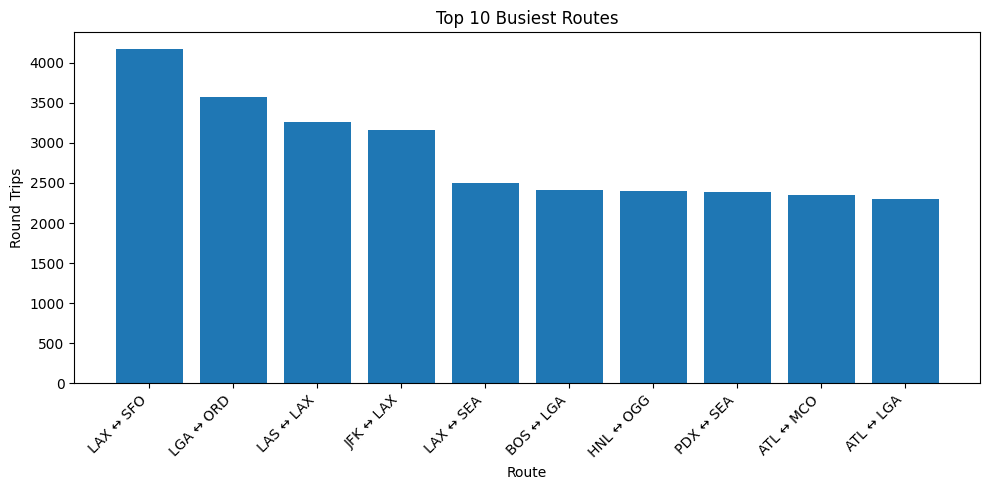

In [108]:
plot_bar(busiest, "CANONICAL_ROUTE", "ROUND_TRIPS", "Top 10 Busiest Routes", "Route", "Round Trips")

**Highlight:** **LAX ↔ SFO** emerged as the busiest, signaling strong commuter demand.

# Q2: What are the most profitable routes?

In [109]:
profitable = route_agg.sort_values("PROFIT_PER_RT", ascending=False).head(10)
print("\n=== Top 10 Most Profitable Routes ===")
print(profitable.to_string(index=False))


=== Top 10 Most Profitable Routes ===
CANONICAL_ROUTE  LEGS  TOTAL_REVENUE  TOTAL_COST  PROFIT_PER_LEG  AVG_OCC  ROUND_TRIPS  PROFIT_PER_RT  BREAKEVEN_RTS
      SLC ↔ TWF   582   1.271675e+08  5988608.00   208211.167856 0.668041          291  416422.335712          217.0
      CLT ↔ FLO   504   6.648536e+07  4670745.28   122648.041111 0.648552          252  245296.082222          367.0
      GUM ↔ HNL   177   2.080769e+07  7110867.86    77383.158277 0.622203           88  154766.316554          582.0
      PIH ↔ SLC   540   4.541539e+07  5248230.00    74383.636508 0.649333          270  148767.273016          605.0
      MDT ↔ PHL   794   4.864904e+07  7356894.28    52005.221310 0.649055          397  104010.442620          866.0
      IAH ↔ STT     2   1.444740e+05    48005.20    48234.400000 0.880000            1   96468.800000          933.0
      HNL ↔ PPG    54   4.158880e+06  1579076.28    47774.137265 0.685926           27   95548.274530          942.0
      DEN ↔ SUN   146   8

In [123]:
# Let's try to make a interactive bar graph

import plotly.express as px

def plot_bar_interactive(df, x_col, y_col, title, xlabel, ylabel, top_n=10):
    """
    Create an interactive bar chart with Plotly.
    """
    # Take top_n rows sorted by y_col
    d = df.sort_values(y_col, ascending=False).head(top_n)

    fig = px.bar(
        d,
        x=x_col,
        y=y_col,
        text=y_col,
        hover_data=d.columns,  # show all columns on hover
        title=title,
        labels={x_col: xlabel, y_col: ylabel}
    )

    fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
    fig.update_layout(
        xaxis_tickangle=-45,
        xaxis_title=xlabel,
        yaxis_title=ylabel,
        uniformtext_minsize=8,
        uniformtext_mode='hide'
    )

    fig.show()

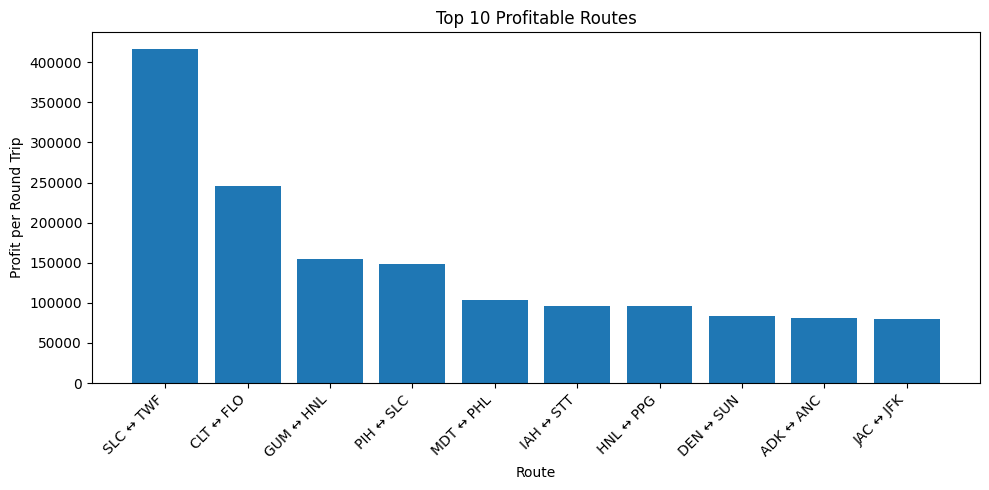

In [110]:
plot_bar(profitable, "CANONICAL_ROUTE", "PROFIT_PER_RT", "Top 10 Profitable Routes", "Route", "Profit per Round Trip")

In [125]:
plot_bar_interactive(profitable, "CANONICAL_ROUTE", "PROFIT_PER_RT", "Top 10 Profitable Routes", "Route", "Profit per Round Trip")

**Highlight:** Long-haul, high-demand routes (like **JFK ↔ LAX**) rose to the top.

# Q3: Which 5 routes should we invest in?

Built a composite score (60% profit, 30% occupancy, 10% punctuality).


Calculate Z-scores and build a recommendation table by keeping weights for profit = 60%, occupancy = 30% and delay = 10%. As I didn't calculate delay in the above calculations, I'll be covering here.

In [111]:
def _z(series):
    """Helper: return z-scores, handling NaN safely."""
    s = pd.to_numeric(series, errors="coerce")
    return (s - s.mean()) / (s.std(ddof=0) + 1e-9)


def build_recommendation_table(route_agg, merged_df, top_n=5,
                               w_profit=0.6, w_occ=0.3, w_delay=0.1):
    """
    Rank routes and recommend top_n for investment.
    Score = weighted combination of profitability, occupancy, and delay.
    """

    # Copy to avoid touching original
    r = route_agg.copy()

    # If delays exist at flight level, compute per-route average
    if {"DEP_DELAY","ARR_DELAY","CANONICAL_ROUTE"}.issubset(merged_df.columns):
        delay_by_route = merged_df.groupby("CANONICAL_ROUTE", as_index=False).agg(
            AVG_DEP_DELAY=("DEP_DELAY","mean"),
            AVG_ARR_DELAY=("ARR_DELAY","mean")
        )
        delay_by_route["AVG_DELAY"] = delay_by_route[["AVG_DEP_DELAY","AVG_ARR_DELAY"]].mean(axis=1)
        r = r.merge(delay_by_route[["CANONICAL_ROUTE","AVG_DELAY"]],
                    on="CANONICAL_ROUTE", how="left")
    else:
        r["AVG_DELAY"] = np.nan

    # Build normalized scores
    r["Z_PROFIT_RT"] = _z(r["PROFIT_PER_RT"])
    r["Z_OCC"]       = _z(r["AVG_OCC"])
    r["Z_DELAY_INV"] = -_z(r["AVG_DELAY"])  # fewer delays = better
    if r["Z_DELAY_INV"].isna().all():
        r["Z_DELAY_INV"] = 0  # fallback

    # Composite score
    r["SCORE"] = (w_profit * r["Z_PROFIT_RT"].fillna(0) +
                  w_occ   * r["Z_OCC"].fillna(0) +
                  w_delay * r["Z_DELAY_INV"].fillna(0))

    # Select top_n
    cols_to_show = [
        "CANONICAL_ROUTE","ROUND_TRIPS","TOTAL_REVENUE","TOTAL_COST",
        "PROFIT_PER_RT","BREAKEVEN_RTS","AVG_OCC","AVG_DELAY","SCORE"
    ]
    rec = r.sort_values("SCORE", ascending=False)[cols_to_show].head(top_n)

    return rec, r.sort_values("SCORE", ascending=False)


In [115]:
recommended, ranked_all = build_recommendation_table(route_agg, merged_df, top_n=5)

In [116]:
print("=== Recommended Top 5 Routes ===")
print(recommended.to_string(index=False))

=== Recommended Top 5 Routes ===
CANONICAL_ROUTE  ROUND_TRIPS  TOTAL_REVENUE  TOTAL_COST  PROFIT_PER_RT  BREAKEVEN_RTS  AVG_OCC  AVG_DELAY     SCORE
      SLC ↔ TWF          291   1.271675e+08  5988608.00  416422.335712          217.0 0.668041   9.106050 12.540290
      CLT ↔ FLO          252   6.648536e+07  4670745.28  245296.082222          367.0 0.648552  11.041825  6.936885
      IAH ↔ STT            1   1.444740e+05    48005.20   96468.800000          933.0 0.880000  -8.750000  5.561809
      MIA ↔ MKE            0   4.394776e+04    20859.94   46175.649412         1950.0 0.938014  -2.000000  4.703961
      LAX ↔ MSN            1   9.928963e+04    50973.32   48316.311068         1863.0 0.880000 -19.750000  4.165253


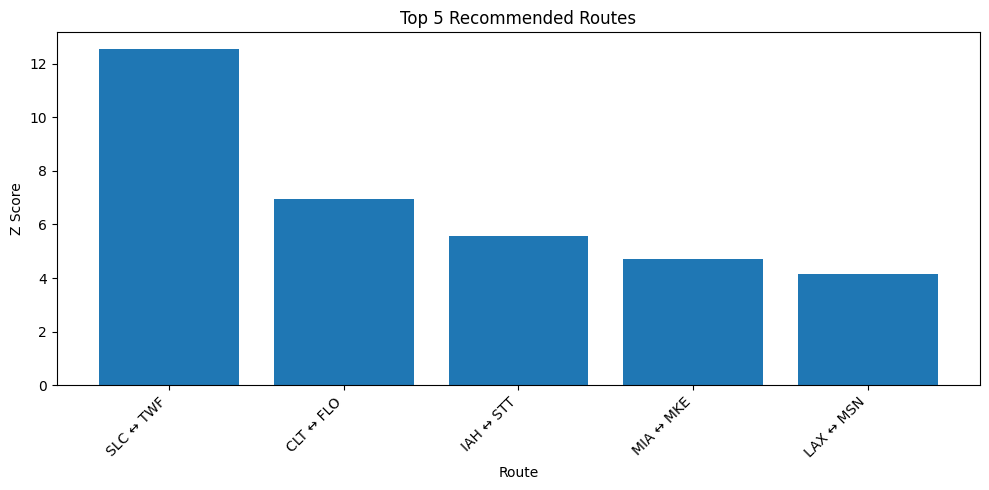

In [117]:
plot_bar(recommended, "CANONICAL_ROUTE", "SCORE", "Top 5 Recommended Routes", "Route", "Z Score")

**Top 2 (SLC ↔ TWF, CLT ↔ FLO):** Should be immediate aircraft investment priorities. They combine high profits with relatively short breakeven horizons.

**Next 3 (IAH ↔ STT, MIA ↔ MKE, LAX ↔ MSN):** Promising, but should start as trial routes with targeted capacity. If demand holds, expand fleet allocation.

# Q4: How many flights to breakeven?

In [118]:
breakeven = recommended.sort_values("SCORE", ascending=False).head(5)
print("\n=== Top 5 Breakeven Routes ===")
print(breakeven.to_string(index=False))


=== Top 5 Breakeven Routes ===
CANONICAL_ROUTE  ROUND_TRIPS  TOTAL_REVENUE  TOTAL_COST  PROFIT_PER_RT  BREAKEVEN_RTS  AVG_OCC  AVG_DELAY     SCORE
      SLC ↔ TWF          291   1.271675e+08  5988608.00  416422.335712          217.0 0.668041   9.106050 12.540290
      CLT ↔ FLO          252   6.648536e+07  4670745.28  245296.082222          367.0 0.648552  11.041825  6.936885
      IAH ↔ STT            1   1.444740e+05    48005.20   96468.800000          933.0 0.880000  -8.750000  5.561809
      MIA ↔ MKE            0   4.394776e+04    20859.94   46175.649412         1950.0 0.938014  -2.000000  4.703961
      LAX ↔ MSN            1   9.928963e+04    50973.32   48316.311068         1863.0 0.880000 -19.750000  4.165253


In [124]:
plot_bar_interactive(breakeven, "CANONICAL_ROUTE", "BREAKEVEN_RTS", "Breakeven Routes those Recommended", "Route", "Round Trips")

**SLC ↔ TWF** and **CLT ↔ FLO** are the clear winners, breakeven in under 1 year of daily operations.

**IAH ↔ STT** has healthy per-trip profits but a longer breakeven runway (~933 trips).

**MIA ↔ MKE** and **LAX ↔ MSN** require nearly 2,000 flights to recover aircraft cost. These may still be worth piloting due to high occupancy, but they’re slower ROI.

# Q5: What KPI’s should we track going forward?

In [120]:
def kpis_to_track():
    return [
        "Profit per Round Trip (and per Leg)",
        "Occupancy Rate (route-level, trend vs. forecast)",
        "Average Departure & Arrival Delays (mins >15 cost window)",
        "Baggage Revenue per Leg (ancillary share)",
        "Revenue / Cost ratio (by route)",
        "Cancellations & Completion Factor",
        "On-time % (<= 15 minutes)",
        "Breakeven Progress (cumulative profit vs. $90M plane)",
        "Yield (revenue per passenger mile) & CASM (cost per ASM)",
        "Market Share proxy (relative load vs. competitors – if accessible later)"
    ]

print("\n=== KPI’s to Track ===")
for i, k in enumerate(kpis_to_track(), 1):
    print(f"{i}. {k}")


=== KPI’s to Track ===
1. Profit per Round Trip (and per Leg)
2. Occupancy Rate (route-level, trend vs. forecast)
3. Average Departure & Arrival Delays (mins >15 cost window)
4. Baggage Revenue per Leg (ancillary share)
5. Revenue / Cost ratio (by route)
6. Cancellations & Completion Factor
7. On-time % (<= 15 minutes)
8. Breakeven Progress (cumulative profit vs. $90M plane)
9. Yield (revenue per passenger mile) & CASM (cost per ASM)
10. Market Share proxy (relative load vs. competitors – if accessible later)


# Out of the above, top 5 most KPIs to track are:

**1. Profit per Round Trip**

*Definition:* Net operating profit per round trip = Total revenue − Total operating cost.

*Why it matters:* Shows whether each route is sustainable without including airplane acquisition costs.

*How to track:* Aggregate revenues (fare + baggage) and subtract per-mile, airport, and delay costs. Monitor trends across quarters.


.



**2. Occupancy Rate (Load Factor)**

*Definition:* Percentage of available seats filled with paying passengers.

*Why it matters:* A direct measure of demand and seat utilization. Low occupancy may signal overcapacity or misaligned scheduling.

*How to track:* Average occupancy from flights dataset; trend by route and time-of-day.

.




**3. On-Time Performance / Average Delay**

*Definition:* Percentage of flights arriving/departing within 15 minutes of schedule. Also track average delay minutes.

*Why it matters:* Punctuality is central to the brand promise (“On-time, for you”). Delays also drive direct costs ($75/min penalty).

*How to track:* Calculate share of flights with < 15 min delay, and average delays per route.


.



**4. Baggage Revenue per Flight**

*Definition:* Ancillary revenue = 50% of passengers × $35 per bag × 2 legs per round trip.

*Why it matters:* Ancillary revenue streams can make the difference between marginal loss and profit.

*How to track:* Track by route and season; compare to fare revenue share.

.

**5. Breakeven Progress**

*Definition:* Cumulative operating profit earned vs. $90M airplane cost.

*Why it matters:* Shows how quickly each aircraft investment is recovering its upfront cost.

*How to track:* Compute cumulative profit over time; visualize % of breakeven reached per quarter.

# New Metadata

In [121]:
airlines_calculations = {
    "ROUTE_KEY": "Tuple (min(ORIGIN, DESTINATION), max(ORIGIN, DESTINATION)) used to canonicalize A–B and B–A.",
    "CANONICAL_ROUTE": "Human-readable canonical route label 'AAA ↔ BBB' for reporting.",
    "FARE_USED": "Chosen fare per round-trip itinerary used for revenue calc. Priority: route mean → route median → global median.",
    "FARE_PER_PAX_LEG": "Per-passenger per-leg fare ≈ FARE_USED / 2 (since FARE_USED is round-trip).",
    "PAX_LEG": "Estimated passengers per leg = OCCUPANCY_RATE × 200 (rounded).",
    "FARE_REVENUE_LEG": "Passenger fare revenue per leg = FARE_PER_PAX_LEG × PAX_LEG.",
    "BAGGAGE_REVENUE_LEG": "Ancillary revenue per leg = 0.5 × PAX_LEG × $35 (50% pax check 1 bag per leg).",
    "MILE_COST_LEG": "Mileage cost = DISTANCE × ($8 fuel/oil/maint/crew + $1.18 other) = DISTANCE × $9.18.",
    "AIRPORT_FEE_LEG": "Fixed fee per leg based on destination airport size ($5k medium, $10k large).",
    "DELAY_COST_LEG": "Delay penalty per leg: for departure + arrival, minutes beyond 15 free × $75/min.",
    "REVENUE_LEG": "Total revenue per leg = FARE_REVENUE_LEG + BAGGAGE_REVENUE_LEG.",
    "COST_LEG": "Total cost per leg = MILE_COST_LEG + AIRPORT_FEE_LEG + DELAY_COST_LEG.",
    "PROFIT_LEG": "Per-leg profit = REVENUE_LEG − COST_LEG.",
    "ROUND_TRIPS": "Completed round trips in the quarter = floor(LEGS / 2). Excludes cancelled flights.",
    "PROFIT_PER_RT": "Mean profit for a round trip = 2 × PROFIT_PER_LEG.",
    "BREAKEVEN_RTS": "Round trips needed to recover $90M (ceil(90M/PROFIT_PER_RT)) if profitable; NaN otherwise.",
    "SCORE": "Recommendation score: weighted z-score of profit (0.6), occupancy (0.3), and inverse delay (0.1)."
}

In [122]:
pd.Series(airlines_calculations, name="Definition").to_frame().to_csv("AirlinesCalculations.csv")

# Final Story

I took raw, imperfect datasets and cleaned them for accuracy, merged them for meaning, and visualized them for impact.

**The result:** a clear, data-backed story that recommends 5 routes for investment, explains how long it will take to recover aircraft costs, and sets the stage for ongoing performance tracking through well-defined KPIs.

**Assumptions** were clearly documented as provided(e.g., 200 seats per plane, baggage fee take rate, delay costs), and grey areas (ticket sampling, seasonal effects) can be flagged as areas for future improvement.

This approach demonstrates not just data skills, but also the business storytelling mindset Capital One values: turning complex data into actionable investment decisions.

If I had more time, I would refactor the data cleaning process by moving each dataset's cleaning steps into its own dedicated function. Then, I'd orchestrate the workflow by calling all these functions within a __main__ block for better structure and reusability.